In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import animation
import random as rnd

rc('animation', html='jshtml')

In [2]:
# Constant to obtain box dimensions given the number of particles per row 
crystal_spacing = 1.07

# Boltzmann constant
kB = 1.38064852 * 10**-23

# Number of steps between heat capacity output
N_OUTPUT_HEAT_CAP = 1000

In [3]:
# Generate two Gaussian random numbers with standard deviation sigma, mean 0
def gaussianRandomNumbers(sigma):
    w = 2
    while (w >= 1):
        rx1 = 2 * rnd.random() - 1
        rx2 = 2 * rnd.random() - 1
        w = rx1 * rx1 + rx2 * rx2 
    w = math.sqrt(-2 * math.log(w) / w)
    return sigma * rx1 * w, sigma * rx2 * w

# Assigns Gaussian distributed velocities given an energy per particle
def thermalize(vx, vy, sqrtKineticEnergyPerParticle):
    for i in range(0, len(vx)):
        vx[i], vy[i] = gaussianRandomNumbers(sqrtKineticEnergyPerParticle)

# Calculate the shortest periodic distance, unit cell [0,Lx],[0,Ly]
# Returns the difference along x, along y and the distance
# This code assumes all particles are within [0,Lx],[0,Ly]
def pbc_dist(x1, y1, x2, y2, Lx, Ly):
    dx = x1 - x2
    dy = y1 - y2
    while dx < -0.5*Lx:
        dx += Lx
    while dx > 0.5*Lx:
        dx -= Lx
    while dy < -0.5*Ly:
        dy += Ly
    while dy > 0.5*Ly:
        dy -= Ly
    return dx, dy, math.sqrt(dx*dx + dy*dy)


In [4]:
# The pair potential
def pairEnergy(r):
    # TODO
    # Implement the pair energy calculation here!
    return 0

# The pair force              
def pairForce(r):
    # TODO
    # Implement the pair force calculation here!
    return 0

In [5]:
class MDsimulator:

    """
        This class encapsulates the whole MD simulation algorithm
    """

    def __init__(self,
                 n=24,
                 L=6.7,
                 mass=1.0,
                 numPerRow=6,
                 T=0.4,
                 dt=0.01,
                 nsteps=20000,
                 numStepsPerFrame=100,
                 startStepForAveraging=100
                 ):
        """
            This is the class 'constructor'; if you want to try different simulations with different parameters 
            (e.g. temperature) in the same scrip, allocate another simulator by passing a different value as input
            argument. See the examples at the end of the script.
        """

        # Initialize simulation parameters and box
        self.n = n
        self.mass = 1.0
        self.invmass = 1.0/mass
        self.numPerRow = numPerRow
        self.Lx = L
        self.Ly = L
        self.T = T
        self.kBT = kB*T
        self.dt = dt
        self.nsteps = nsteps
        self.numStepsPerFrame = numStepsPerFrame
        # Initialize positions, velocities and forces
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        self.fx = []
        self.fy = []
        for i in range(n):
            self.x.append(crystal_spacing *
                          ((i % numPerRow) + 0.5*(i / numPerRow)))
            self.y.append(crystal_spacing*0.87*(i/numPerRow))
            self.vx.append(0.0)
            self.vy.append(0.0)
            self.fx.append(0.0)
            self.fy.append(0.0)
        thermalize(self.vx, self.vy, np.sqrt(self.kBT/self.mass))
        # Initialize containers for energies
        self.sumEpot = 0
        self.sumEpot2 = 0
        self.sumPV = 0
        self.outt = []
        self.ekinList = []
        self.epotList = []
        self.etotList = []
        self.pvList = []
        self.startStepForAveraging = startStepForAveraging
        self.step = 0
        self.Epot = 0
        self.Ekin = 0
        self.PV = 0
        self.Cv = 0
        # Initialize figure for animation
        self.fig = plt.figure()
        self.ax = plt.subplot(xlim=(0, self.Lx), ylim=(0, self.Ly))

    def clear_energy_potential(self):
        """
            Clear the temporary variables storing potential and kinetic energy
            Resets forces to zero
        """

        self.Epot = 0
        self.Ekin = 0
        for i in range(0, self.n):
            self.fx[i] = 0
            self.fy[i] = 0

    def update_forces(self):
        """
            Updates forces and potential energy using functions
            pairEnergy and pairForce (which you coded above...)
            Returns the virial: 1/2 sum f*r
        """

        sum_f_times_r = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                dx, dy, r = pbc_dist(
                    self.x[i], self.y[i], self.x[j], self.y[j], self.Lx, self.Ly)
                self.Epot += pairEnergy(r)
                fij = pairForce(r)
                self.fx[i] += fij * dx / r
                self.fy[i] += fij * dy / r
                self.fx[j] -= fij * dx / r
                self.fy[j] -= fij * dy / r
                sum_f_times_r += fij * r

        # Here we divide by 4 instead of 2 because we double-counted the forces
        return -sum_f_times_r / 4

    def propagate(self):
        """
            Performs an Hamiltonian propagation step and
            rescales velocities to match the input temperature 
            (THE LATTER YOU NEED TO IMPLEMENT!)
        """

        for i in range(0, self.n):
            # At the first step we alread have the "full step" velocity
            if self.step > 0:
                # Update the velocities with a half step
                self.vx[i] += self.fx[i]*self.invmass*0.5*self.dt
                self.vy[i] += self.fy[i]*self.invmass*0.5*self.dt

            # TODO
            # When temperature coupling, modify the velocity of one or more particles here

            # Add the kinetic energy of particle i to the total
            self.Ekin += 0.5*self.mass * \
                (self.vx[i]*self.vx[i] + self.vy[i]*self.vy[i])
            # Update the velocities with a half step
            self.vx[i] += self.fx[i]*self.invmass*0.5*self.dt
            self.vy[i] += self.fy[i]*self.invmass*0.5*self.dt
            # Update the coordinates
            self.x[i] += self.vx[i] * self.dt
            self.y[i] += self.vy[i] * self.dt
            # Apply p.c.b. and put particles back in the unit cell
            self.x[i] = self.x[i] % self.Lx
            self.y[i] = self.y[i] % self.Ly

    def md_step(self):
        """
            Performs a full MD step
            (computes forces, updates positions/velocities)
        """

        # This function performs one MD integration step
        self.clear_energy_potential()
        virial = self.update_forces()
        self.propagate()
        self.PV = 2 * (self.Ekin - virial)
        # Start averaging only after some initial spin-up time
        if self.step > self.startStepForAveraging:
            self.sumEpot += self.Epot
            self.sumEpot2 += self.Epot * self.Epot
            self.sumPV += self.PV
        self.step += 1

    def integrate_some_steps(self, framenr=None):
        """
            Performs MD steps in a prescribed time window
            Stores energies and heat capacity
        """

        for j in range(self.numStepsPerFrame):
            self.md_step()
        t = self.step*self.dt
        self.outt.append(t)
        self.ekinList.append(self.Ekin)
        self.epotList.append(self.Epot)
        self.etotList.append(self.Epot + self.Ekin)
        self.pvList.append(self.PV)
        if self.step >= self.startStepForAveraging and self.step % N_OUTPUT_HEAT_CAP == 0:
            EpotAv = self.sumEpot/(self.step + 1 - self.startStepForAveraging)
            Epot2Av = self.sumEpot2 / \
                (self.step + 1 - self.startStepForAveraging)
            self.Cv = (Epot2Av - EpotAv * EpotAv) / (self.kBT * self.T)
            pvAv = self.sumPV/(self.step + 1 - self.startStepForAveraging)
            print('time', t, '<Cv> =', self.Cv, "<P>V =", pvAv)

    def snapshot(self, framenr=None):
        """
            This is an 'auxillary' function needed by animation.FuncAnimation
            in order to show the animation of the 2D Lennard-Jones system
        """

        self.integrate_some_steps(framenr)
        return self.ax.scatter(self.x, self.y, s=1500, marker='o', c="r"),

    def simulate(self):
        """
            Performs the whole MD simulation
            If the total number of steps is not divisible by the frame size, then
            the simulation will run for nsteps-(nsteps%numStepsPerFrame) steps
        """

        nn = self.nsteps//self.numStepsPerFrame
        print("T="+str(self.T)+", integrating for " +
              str(nn*self.numStepsPerFrame)+" steps ...")
        for i in range(nn):
            self.integrate_some_steps()

    def simulate_animate(self):
        """
            Performs the whole MD simulation, while producing and showing the
            animation of the molecular system
            CAREFUL! This will slow down the script execution considerably
        """

        nn = self.nsteps//self.numStepsPerFrame
        print("T="+str(self.T)+", integrating for " +
              str(nn*self.numStepsPerFrame)+" steps ...")
        anim = animation.FuncAnimation(self.fig, self.snapshot,
                                       frames=nn, interval=50, blit=True, repeat=True)
        plt.show()  # show the animation
        # You may want to (un)comment the following 'waitforbuttonpress', depending on your environment
        # plt.waitforbuttonpress(timeout=20)

        return anim

    def plot_energy(self):
        """
            Plots kinetic, potential and total energy over time
        """

        plt.figure()
        plt.xlabel('time')
        plt.ylabel('energy')
        plt.plot(self.outt, self.ekinList, self.outt, self.epotList,
                 self.outt, self.etotList, self.pvList)
        plt.legend(('Ekin', 'Epot', 'Etot', 'PV'))
        plt.show()


In [6]:
def main():

    # Calling one simulator, animating and plotting
    simulator = MDsimulator()
    anim = simulator.simulate_animate()
    simulator.plot_energy()

    # Calling several simulators and storing heat capacity
    temperature_values = []  # [0.2, 0.4, 0.6, 0.8]
    cv_values = []
    for TT in temperature_values:
        simulator = MDsimulator(T=TT)
        simulator.simulate()
        cv_values.append(simulator.Cv)
    # TODO
    # Plotting and analyzing results ...

    return anim


T=0.4, integrating for 20000 steps ...


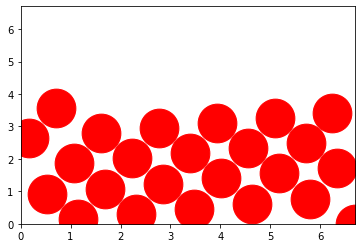

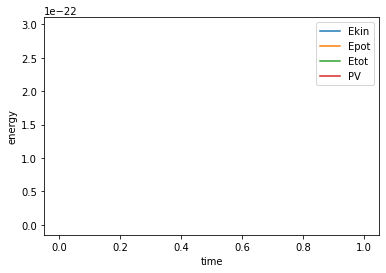

In [7]:
# Calling 'main()' if the script is executed.
# If the script is instead just imported, main is not called (this can be useful if you want to
# write another script importing and utilizing the functions and classes defined in this one)
anim = main()

In [8]:
anim

time 10.0 <Cv> = 0.0 <P>V = 2.9502397651886025e-22
time 20.0 <Cv> = 0.0 <P>V = 2.9536923590931813e-22
time 30.0 <Cv> = 0.0 <P>V = 2.954764674538804e-22
time 40.0 <Cv> = 0.0 <P>V = 2.9552872255931642e-22
time 50.0 <Cv> = 0.0 <P>V = 2.9555965340217977e-22
time 60.0 <Cv> = 0.0 <P>V = 2.9558010099038577e-22
time 70.0 <Cv> = 0.0 <P>V = 2.9559462260024104e-22
time 80.0 <Cv> = 0.0 <P>V = 2.9560546831847366e-22
time 90.0 <Cv> = 0.0 <P>V = 2.9561387707047045e-22
time 100.0 <Cv> = 0.0 <P>V = 2.9562058725626244e-22
time 110.0 <Cv> = 0.0 <P>V = 2.9562606632824983e-22
time 120.0 <Cv> = 0.0 <P>V = 2.9563062462517845e-22
time 130.0 <Cv> = 0.0 <P>V = 2.9563447626418464e-22
time 140.0 <Cv> = 0.0 <P>V = 2.9563777375039517e-22
time 150.0 <Cv> = 0.0 <P>V = 2.956406286507107e-22
time 160.0 <Cv> = 0.0 <P>V = 2.9564312446665222e-22
time 170.0 <Cv> = 0.0 <P>V = 2.956453249372365e-22
time 180.0 <Cv> = 0.0 <P>V = 2.956472795589202e-22
time 190.0 <Cv> = 0.0 <P>V = 2.9564902735327383e-22
time 200.0 <Cv> = 0.0 <P>